In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

from joblib import Parallel, delayed

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [53]:
df_calendar = pd.read_csv('calendar.csv')
df_sales = pd.read_csv('sales_train_validation.csv')
df_price = pd.read_csv('sell_prices.csv')

In [4]:
%%time

df_calendar = reduce_mem_usage(df_calendar)
df_sales = reduce_mem_usage(df_sales)
df_price = reduce_mem_usage(df_price)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.19 MB
Decreased by 8.7%
Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.16 MB
Decreased by 78.7%
Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.76 MB
Decreased by 78.1%
CPU times: user 2min 42s, sys: 2min 35s, total: 5min 17s
Wall time: 5min 22s


In [56]:
df_price.shape

(6841121, 4)

In [5]:
for i in range(1914, 1942):
    df_sales['d_'+str(i)] = np.nan

In [6]:
d_colnames = []

#for test
for i in range(1, 1942):
    d_colnames.append('d_'+str(i))
    
sales = pd.melt(df_sales, \
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')
sales['day_number'] = \
    sales['day_number'].apply(lambda x: int(x[2:]))


In [7]:
%%time

sales = reduce_mem_usage(sales)


Memory usage of dataframe is 1355.88 MB
Memory usage after optimization is: 678.60 MB
Decreased by 50.0%
CPU times: user 1.43 s, sys: 599 ms, total: 2.02 s
Wall time: 2.18 s


In [8]:
df_calendar['d'] = \
    df_calendar['d'].apply(lambda x: int(x[2:]))

sales = sales.merge(df_calendar, left_on='day_number', right_on='d', how='left')



In [9]:
sales = reduce_mem_usage(sales)

Memory usage of dataframe is 2484.82 MB
Memory usage after optimization is: 2146.26 MB
Decreased by 13.6%


In [10]:
del df_calendar
del df_sales

gc.collect()

0

In [11]:

df = sales.merge(
    df_price, left_on=['store_id', 'item_id', 'wm_yr_wk'],
    right_on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left')


In [12]:
%%time

df = reduce_mem_usage(df)

Memory usage of dataframe is 2259.14 MB
Memory usage after optimization is: 2259.14 MB
Decreased by 0.0%
CPU times: user 2.79 s, sys: 393 ms, total: 3.19 s
Wall time: 3.24 s


In [13]:
del sales
del df_price
gc.collect()

0

In [14]:
df.drop(['wday', 'd', 'wm_yr_wk'], inplace=True, axis=1)
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week

/Users/Jammy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df.to_pickle("./data.pkl")

In [16]:
df_unpickle = pd.read_pickle("./data.pkl")

In [17]:
df_unpickle = df_unpickle[df_unpickle.day_number.astype(int) > 972]

In [18]:
df_unpickle[~df_unpickle.event_name_1.isnull() & ~df_unpickle.event_name_2.isnull()]

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
35886730,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,...,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,8.257812,16
35886731,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,...,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,3.970703,16
35886732,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1178,0.0,2014-04-20,Sunday,...,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,2.970703,16
35886733,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1178,4.0,2014-04-20,Sunday,...,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,4.640625,16
35886734,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1178,3.0,2014-04-20,Sunday,...,2014,Easter,Cultural,OrthodoxEaster,Religious,0,0,0,3.080078,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37624655,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1234,0.0,2014-06-15,Sunday,...,2014,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,2.880859,24
37624656,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1234,1.0,2014-06-15,Sunday,...,2014,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,2.679688,24
37624657,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1234,1.0,2014-06-15,Sunday,...,2014,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,3.980469,24
37624658,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1234,1.0,2014-06-15,Sunday,...,2014,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1,1.280273,24


In [19]:
item_id = df_unpickle.item_id.unique().to_list()
print(len(item_id))

3049


In [20]:
def snap(row):
    if row['snap_'+ row.state_id] == 1:
        return 1
    return 0

In [21]:
def product_feature_generation(itemid):
    
    product = df_unpickle.loc[df_unpickle.item_id == itemid].copy()
    product['snap'] = product.apply(snap, axis=1)
    product.drop(['snap_CA', 'snap_WI', 'snap_TX'], axis=1, inplace=True)
   

    product.drop(['cat_id', 'state_id', 'date', 'year'], axis=1, inplace=True)
    product['units_lag_28'] = product.groupby('id')['units_sold'].transform(
        lambda x: x.shift(28, fill_value=0)
    )
    
   
    # Rolling units sold for days -28 to -34
    product['mean_rolling_7'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -55
    product['mean_rolling_28'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -76
    product['mean_rolling_49'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).mean()
    )
    product['mean_rolling_84'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).mean()
    )
    product['mean_rolling_140'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).mean()
    )
    

    product['std_rolling_7'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    product['std_rolling_28'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).std()
    )
    product['std_rolling_49'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).std()
    )
    product['std_rolling_84'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).std()
    )
    product['std_rolling_140'] = product.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).std()
    )
    
    product['std_price_rolling_7'] = product.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    product['std_price_rolling_28'] = product.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(28, min_periods=1).std()
    )
    product['price_percent_change'] = product.groupby('id')['sell_price'].pct_change()
    
    product.drop(['id', 'item_id', 'event_name_1', 'event_name_2', 'week'], axis=1, inplace=True)
    
    categorical_cols = ['weekday', 'month']
    for col in categorical_cols:
        product[col] = product[col].astype('category')
    product.reset_index(drop=True, inplace=True)
    
    encoded_cols = pd.get_dummies(product[[
        'dept_id', 'store_id', 'weekday', 'month', 'event_type_1', 'event_type_2'
    ]]).reset_index(drop=True)
    product.drop(['dept_id', 'weekday', 'month', 'event_type_1', 'event_type_2'], axis=1, inplace=True)
    product = pd.concat([product, encoded_cols], axis=1)
    
    # Keep only non-zero rolling value rows
    product = product[product.day_number.astype(int) > 1000]
    
    return product

In [22]:
df_001 = product_feature_generation('HOBBIES_1_001')

### Training /Validation Split

In [24]:
df_train = df_001[df_001.day_number.astype(int) <= 1885].reset_index(drop=True) # 1913-28
df_val = df_001[(df_001.day_number.astype(int) > 1885)
                                         & (df_001.day_number.astype(int) < 1914)].reset_index(drop=True)
df_test = df_001[df_001.day_number.astype(int) >= 1914].reset_index(drop=True)

In [25]:
df_train_x = df_train.iloc[:, 3:]
df_train_y = df_train.units_sold
df_val_x = df_val.iloc[:, 3:]
df_val_y = df_val.units_sold

In [26]:

df_test_x = df_test.iloc[:, 3:]

### Modeling - XGBoost

In [27]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [28]:
model.fit(df_train_x, df_train_y)

[04:03:40] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, learning_rate=0.07, min_child_weight=1.5,
             reg_alpha=0.75, reg_lambda=0.45, seed=42, subsample=0.6)

In [29]:
xgb_preds = np.round(model.predict(df_val_x))

In [30]:
np.sqrt(mean_squared_error(df_val_y.values, xgb_preds))

0.8660254

Text(0, 0.5, 'Feature Importance Score')

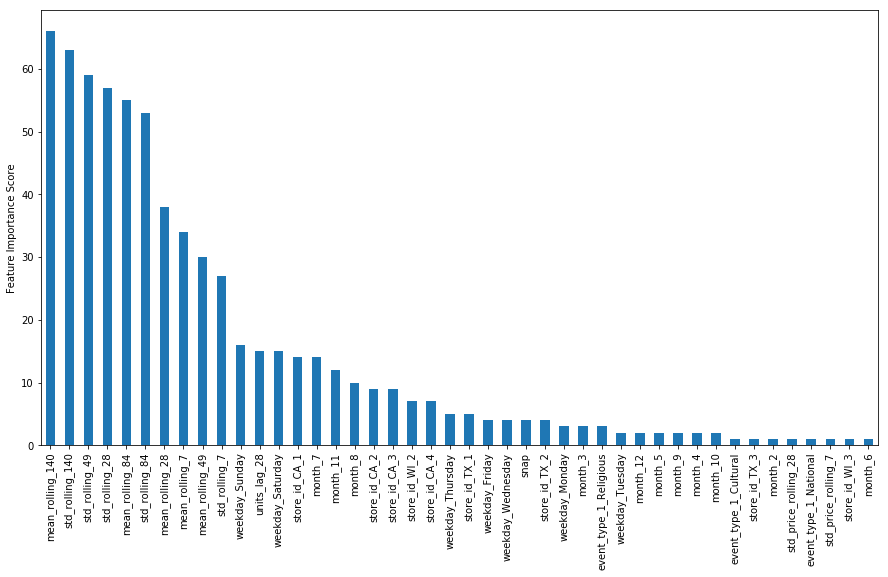

In [31]:
feature_importances = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15, 8))
feature_importances.plot(kind='bar')

plt.ylabel('Feature Importance Score')

## Parameters Tuning

### reg_alpha and reg_lambda

In [42]:
df_x = df_001[df_001.day_number.astype(int) < 1914].iloc[:, 3:]
df_y = df_001[df_001.day_number.astype(int) < 1914].units_sold


In [45]:


tscv = TimeSeriesSplit(n_splits=2)
reg_params = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 0.75, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 0.45, 0.75, 1],
    
}
reg_gsearch = GridSearchCV(estimator = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42), 
             param_grid = reg_params, scoring='neg_mean_squared_error', n_jobs=4,
             cv=tscv.split(df_x))
reg_gsearch.fit(df_x, df_y)
reg_gsearch.best_params_, reg_gsearch.best_score_

[04:16:09] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 0.75, 'reg_lambda': 0.1}, -0.5567851066589355)

In [47]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.1,
                 subsample=0.6,
                 seed=42)
model.fit(df_train_x, df_train_y)
xgb_preds = np.round(model.predict(df_val_x))
np.sqrt(mean_squared_error(df_val_y.values, xgb_preds))

[04:16:51] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8660254

### max_depth

In [48]:
reg_params = {
 'max_depth': range(3,10,2)
    
}
reg_gsearch = GridSearchCV(estimator = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=1,
                 reg_lambda=0.75,
                 subsample=0.6,
                 seed=42), 
             param_grid = reg_params, scoring='neg_mean_squared_error', n_jobs=4, 
             cv=tscv.split(df_x))
reg_gsearch.fit(df_x, df_y)
reg_gsearch.best_params_, reg_gsearch.best_score_

[04:17:09] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 3}, -0.5569222420454025)

In [49]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=2,
                 n_estimators=100,                                                                    
                 reg_alpha=1,
                 reg_lambda=0.75,
                 subsample=0.6,
                 seed=42)
model.fit(df_train_x, df_train_y)
xgb_preds = np.round(model.predict(df_val_x))
np.sqrt(mean_squared_error(df_val_y.values, xgb_preds))

[04:18:04] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8742344

### subsample and colsample_bytree

In [50]:
reg_params = {
    'subsample':[i/10.0 for i in range(0,10)],
    'colsample_bytree':[i/10.0 for i in range(0,10)]
}
reg_gsearch = GridSearchCV(estimator = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=2,
                 n_estimators=100,                                                                    
                 reg_alpha=1,
                 reg_lambda=0.75,
                 subsample=0.6,
                 seed=42), 
             param_grid = reg_params, scoring='neg_mean_squared_error', n_jobs=4, 
             cv=tscv.split(df_x))
reg_gsearch.fit(df_x, df_y)
reg_gsearch.best_params_, reg_gsearch.best_score_

[04:19:46] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.6, 'subsample': 0.9}, -0.5526705831289291)

In [51]:
model = xgb.XGBRegressor(colsample_bytree=0.6,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=2,
                 n_estimators=100,                                                                    
                 reg_alpha=1,
                 reg_lambda=0.75,
                 subsample=0.9,
                 seed=42)
model.fit(df_train_x, df_train_y)
xgb_preds = np.round(model.predict(df_val_x))
np.sqrt(mean_squared_error(df_val_y.values, xgb_preds))

[04:20:14] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8660254